In [102]:


from pathlib import Path


import IPython.display as ipd
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import torchaudio
import matplotlib.pyplot as plt
import time
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F_vision
import pickle
import ipywidgets as widgets
import itertools
from utils import split_to_n_chunks
from metadata import RawDataset

In [2]:
data_dir = Path("./data/")

In [4]:
# # to re-extract metadata, uncomment and run the lines below, they are however cached as
# # pickles and can be loaded instead
# ch_sims = RawDataset(data_dir=data_dir, dataset_name="CH-SIMS", debug=False)
# with open('./data/CH-SIMS.pkl', 'wb') as f:
#     pickle.dump(ch_sims, f)
# cmu_mosei = RawDataset(data_dir=data_dir, dataset_name="CMU-MOSEI", debug=False)
# with open('./data/CMU-MOSEI.pkl', 'wb') as f:
#     pickle.dump(cmu_mosei, f)

In [5]:
with open("./data/CMU-MOSEI.pkl", "rb") as f:
    cmu_mosei = pickle.load(f)
with open("./data/CH-SIMS.pkl", "rb") as f:
    ch_sims = pickle.load(f)

In [6]:
len(cmu_mosei)

22856

In [7]:
len(ch_sims)

4403

In [8]:
durations = np.array([x.duration for x in cmu_mosei] + [x.duration for x in ch_sims])
print(f"mean duration: {np.mean(durations)}")
print(f"90th percentile: {np.percentile(durations, 90)}")
print(f"95th percentile: {np.percentile(durations, 95)}")
print(f"99th percentile: {np.percentile(durations, 99)}")

mean duration: 6.964760340764422
90th percentile: 12.634512471655329
95th percentile: 15.91903401360543
99th percentile: 23.6076707482993


In [9]:
duration_cutoff = 12  # will discard examples longer than 12 seconds
max_audio_embedding_timesteps = 599  # wav2vec2 output on 12 sec audio
max_visual_embedding_timesteps = 30 * duration_cutoff  # 30 fps x 12sec = 360
max_text_embedding_timesteps = 50  # 99th percentile in the dataset

In [10]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=16000,
    padding_value=0.0,
    do_normalize=True,
    return_attention_mask=True,
)
# we are using Wav2Vec2-XLS-R as it is trained on multilingual data
audio_model = Wav2Vec2Model.from_pretrained(
    "facebook/wav2vec2-xls-r-300m", cache_dir="models/"
).cuda()

In [11]:
def extract_audio_embedding(audio, sr):
    audio = audio.mean(dim=0)
    if sr != 16_000:
        # Wav2Vec2 requires audio to be 16kHz
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16_000)
        audio = resampler(audio)
    audio = feature_extractor(
        audio, sampling_rate=16_000, return_tensors="pt"
    ).input_values.cuda()
    with torch.no_grad():
        audio_embeddings = audio_model(audio).last_hidden_state.cpu().squeeze()
    return audio_embeddings, audio.cpu().squeeze()

In [12]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel

# similarly for text, we are using XLM-RoBERTa which was trained on multilingual data
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base", cache_dir="models/")
text_model = XLMRobertaModel.from_pretrained(
    "xlm-roberta-base", cache_dir="models/"
).cuda()

In [13]:
def extract_text_embedding(text: str):
    encoded_input = tokenizer(text, return_tensors="pt")
    encoded_input = {key: val.cuda() for key, val in encoded_input.items()}
    with torch.no_grad():
        text_embeddings = text_model(**encoded_input).last_hidden_state.cpu().squeeze()
    return text_embeddings

In [14]:
from batch_face import RetinaFace
from models_multiview import FrontaliseModelMasks_wider

# for visual embeddings, we are first using RetinaFace to find a cropping box for the face
# and then we are using FAb-Net to extract visual facial embeddings
detector = RetinaFace(gpu_id=0, model_path="./models/RetinaFace/mobilenet0.25_Final.pth")
visual_model = FrontaliseModelMasks_wider(
    input_nc=3, inner_nc=256, num_additional_ids=32
)
visual_model.load_state_dict(
    torch.load("./models/fabnet/affectnet_4views.pth")["state_dict_model"]
)
visual_model = visual_model.eval().cuda()

32 256


In [15]:
def find_largest_face(faces: list):
    # a lot of videos in CMU-MOSEI come from DVD reviews. These often have actors faces
    # in the frame. A good heuristic for finding the face of the speaker is finding the
    # largest face in the frame.
    ix = -1
    max_area = -1
    for i, face in enumerate(faces):
        bbox, _, conf = face
        if conf < 0.99:
            continue
        face_width = bbox[2] - bbox[0]
        face_height = bbox[3] - bbox[1]
        face_area = face_width * face_height
        if face_area > max_area:
            ix = i
            max_area = face_area

    if ix != -1:
        return faces[ix]
    return None

In [16]:
MIN_FACE_WIDTH = 30
MIN_FACE_HEIGHT = 60
MIN_FACE_CONFIDENCE = 0.95


def check_faces(faces: list):
    # some videos do not have a face in the frame. we reject these
    # as they won't be useful as training data.
    if len(faces) != 1:
        face = find_largest_face(faces)
        if face is None:
            return None
    else:
        face = faces[0]
    bbox, _, conf = face
    if conf < MIN_FACE_CONFIDENCE:
        return None
    face_width = bbox[2] - bbox[0]
    face_height = bbox[3] - bbox[1]
    if face_width < MIN_FACE_WIDTH:
        return None
    elif face_height < MIN_FACE_HEIGHT:
        return None
    return bbox.round().astype(int)

In [17]:
def crop_face(frame_face):
    # we crop the face to a 256x256 bounding box,
    # adding padding if necessary to center the face.

    frame, face = frame_face
    # frame = (height, width, channels)
    # face = (x_start, y_start, x_end, y_end)
    x_start, y_start, x_end, y_end = face
    x_center = (x_start + x_end) / 2
    y_center = (y_start + y_end) / 2

    width = x_end - x_start
    height = y_end - y_start
    if width > height:
        length = width
    else:
        length = height

    pad = int(length * 0.2)

    padded_x_start = int(x_center - length / 2 - pad)

    padded_y_start = int(y_center - length / 2 - pad)

    frame = torch.tensor(frame).permute(2, 0, 1)
    face_frame = F_vision.resized_crop(
        frame,
        top=padded_y_start,
        left=padded_x_start,
        height=length + 2 * pad,
        width=length + 2 * pad,
        size=[256, 256],
        antialias=True,
    )
    return face_frame

In [18]:
def extract_visual_embedding(frames):
    # the visual embedding pipeline consists of:
    # 1. detect all faces in every frame
    # 2. check the faces for speaker's face
    # 3. crop the frame to center the face of speaker
    # 4. extract embeddings via FAb-Net from the cropepd faces
    size = np.prod(frames.shape[:-1])
    split_to = int(np.ceil(size / 99901440)) # to avoid GPU OOM errors
    frames_batched = list(split_to_n_chunks(frames, n=split_to))
    faces_in_frames = [detector.detect(frames, chunk_size=frames.shape[0]) for frames in frames_batched]
    faces_in_frames = list(itertools.chain(*faces_in_frames))
    faces_in_frames = map(check_faces, faces_in_frames)
    face_frames = list(
        map(
            crop_face,
            filter(
                lambda frame_face: frame_face[1] is not None,
                zip(frames, faces_in_frames),
            ),
        )
    )
    if len(face_frames) < 5:
        return None, None
    face_frames = torch.stack(face_frames)
    face_frames_cuda = F_vision.convert_image_dtype(face_frames).cuda()
    with torch.no_grad():
        visual_embeddings = visual_model.encoder(face_frames_cuda).cpu().squeeze()
    return visual_embeddings, face_frames.permute(0, 2, 3, 1)

In [19]:
def plot_face(face_frames: torch.Tensor, index: int):
    plt.imshow(face_frames[index])

In [20]:
# i = np.random.randint(0, len(cmu_mosei))
# print(i)
# metadata = cmu_mosei[i]
# metadata.play_video()

In [21]:
# audio_embedding, audio = extract_audio_embedding(*metadata.get_audio())
# text_embedding = extract_text_embedding(metadata.text)
# visual_embedding, face_frames = extract_visual_embedding(
#     metadata.get_video_frames(fps=30)
# )

In [22]:
# text_embedding.shape

In [23]:
# audio_embedding.shape

In [24]:
# visual_embedding.shape

In [25]:
# _ = widgets.interact(
#     plot_face,
#     index=(0, len(face_frames) - 1, 1),
#     face_frames=widgets.fixed(face_frames),
# )

In [96]:
preprocessed_dir = Path("./data/preprocessed/")
datasets = {"CMU-MOSEI": cmu_mosei, "CH-SIMS": ch_sims}
text_embedding_sizes = []
audio_embedding_sizes = []
visual_embedding_sizes = []
failed = {}
processed = {}

In [97]:
missing = {}
missing_plot = {}

In [98]:

for dataset_name, dataset in datasets.items():
    missing[dataset_name] = []
    missing_plot[dataset_name] = []
    for i, metadata in enumerate(tqdm(dataset)):
        utterance_id = f"{metadata.video_id}_{metadata.clip_id}"
        split = metadata.split.name
        split_dir = preprocessed_dir / dataset_name / split
        export_path = split_dir / utterance_id
        if metadata.duration > duration_cutoff:
            continue
        if export_path.exists():
            missing_plot[dataset_name].append(1)
            continue
        else:
            missing[dataset_name].append(metadata)
            missing_plot[dataset_name].append(0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4403/4403 [00:00<00:00, 122303.89it/s]


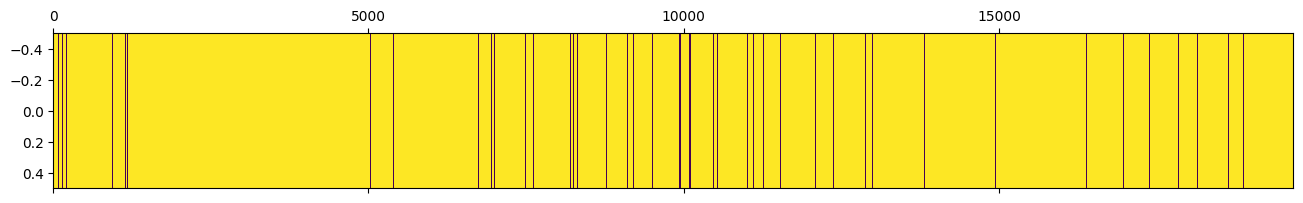

In [99]:
plt.matshow(np.array(missing_plot['CMU-MOSEI'])[:, None].T, aspect='auto')

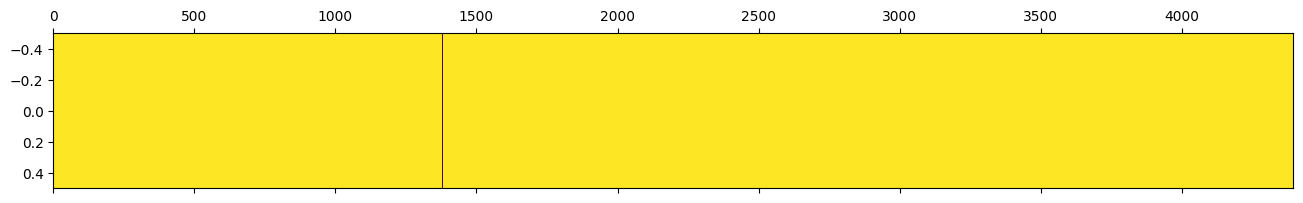

In [100]:
plt.matshow(np.array(missing_plot['CH-SIMS'])[:, None].T, aspect='auto')

In [89]:
# del missing['CMU-MOSEI']

In [101]:
# # for dataset_name, dataset in datasets.items():
# for dataset_name, dataset in missing.items():
#     failed[dataset_name] = []
#     processed[dataset_name] = []
#     for i, metadata in enumerate(tqdm(dataset)):
#         utterance_id = f"{metadata.video_id}_{metadata.clip_id}"
#         split = metadata.split.name
#         split_dir = preprocessed_dir / dataset_name / split
#         split_dir.mkdir(parents=True, exist_ok=True)
#         if metadata.duration > duration_cutoff:
#             continue
#         visual_embedding, face_frames = extract_visual_embedding(
#             metadata.get_video_frames(fps=30)
#         )
#         if visual_embedding is None:
#             failed[dataset_name].append(metadata)
#             continue
#         audio_embedding, audio = extract_audio_embedding(*metadata.get_audio())
#         text_embedding = extract_text_embedding(metadata.text)

#         datum = {"v": visual_embedding, "a": audio_embedding, "t": text_embedding}
#         visual_embedding_sizes.append(visual_embedding.shape[0])
#         audio_embedding_sizes.append(audio_embedding.shape[0])
#         text_embedding_sizes.append(text_embedding.shape[0])
#         torch.save(datum, split_dir / f'{utterance_id}.pt')